# Fit model parameters to multivariable data (voltage & temperature)

This notebook demonstrates how to fit a model to data but for multiple variables. In this case, we will fit the Thermal Single Particle Model with electrolyte (TSPMe) to voltage and temperature data. It builds upon the [single variable example notebook](./datafit_single_variable.ipynb) and assumes the reader has read and understood that notebook.

The steps follow in a similar way, but we now will make use of some additional and optional features. We start by importing the relevant packages, as usual.

In [1]:
#%pip install git+https://github.com/paramm-team/pybamm-param.git -q # Can be used for Google Colab
import pybamm
import pbparam
import pandas as pd
import os

## 1. Load the data
The first step is to load the data to which we want to fit the model. For this example, we use the experimental dataset which from [Brosa Planella et al. (2021) article](https://www.sciencedirect.com/science/article/pii/S0013468621008148). This data set is already in the right format, if you are using your own dataset you should ensure that the headers of the relevant columns match the variable names in PyBaMM (e.g. `"Time [s]"`, `"Voltage [V]"`...)

In [2]:
os.chdir(os.path.join(pbparam.__path__[0], "input", "data")) # Path change
data = pd.read_csv("LGM50_789_1C_25degC.csv")

## 2. Define the model
Next we need to define the model we want to fit to the data, in this case the TSPMe model. 

In [3]:
model = pybamm.lithium_ion.SPMe(
    options={
        "thermal": "lumped",
        "dimensionality": 0,
        "cell geometry": "arbitrary",
        "electrolyte conductivity": "integrated",
    },
    name="TSPMe",
)

We want to fit the model, amongst others, to the reaction coefficient in the negative electrode. This parameter is not readily available in PyBaMM (it uses the exchange current density as a whole) but we can easily bypass this with some simple coding. In order to optimise the reaction coefficient, we need to redefine the exchange current density and define the rate as a parameter:

In [4]:
def j0_neg(c_e, c_s_surf, c_s_max, T):
    """
    This function has been copied from the Chen2020 parameter set:
    pybamm/input/parameters/lithium_ion/negative_electrodes/graphite_Chen2020
    /graphite_LGM50_electrolyte_exchange_current_density_Chen2020.py
    Similar could be done for the positive exchange current density
    """
    m_ref = pybamm.Parameter("Negative electrode reaction coefficient")
    E_r = 3500
    arrhenius = pybamm.exp(E_r / pybamm.constants.R * (1 / 298.15 - 1 / T))
    return (
        m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
    )

Then we can call the `"Chen2020"` parameter set and update the exchange current density to use the `j0_neg` function we just defined. We will also have to provide a value for the newly defined `"Negative electrode reaction coefficient"`.

In [5]:
param = pybamm.ParameterValues("Chen2020")  # Initial parameters to be used.

# Update some parameters to match the experimental setup
param.update(
    {
        "Negative electrode diffusivity [m2.s-1]": 2e-14,
        "Initial concentration in positive electrode [mol.m-3]": 17150,
        "Negative electrode exchange-current density [A.m-2]": j0_neg,
        "Negative electrode reaction coefficient": 6.48e-7,
        "Total heat transfer coefficient [W.m-2.K-1]": 16,
        "Ambient temperature [K]": 297.825,
        "Initial temperature [K]": 297.825,
    },
    check_already_exists=False,
)

We define the experiment and the simulation as usual.

In [6]:
experiment = pybamm.Experiment(
    [
        "Discharge at 1C until 2.5 V",
        "Rest for 2 hours",
    ],
)

simulation = pybamm.Simulation(
    model,
    parameter_values=param,
    experiment=experiment,
)

## 3. Define the optimisation problem
Now we need to define the optimisation problem; we will use `DataFit` again. We first define the parameters we want to optimise and provide initial guesses and bounds. Note that now we have wrapped all the heat capacities in a tuple, which will enforce they take the same value. This hack is to bypass the fact that PyBaMM computes the lumped thermal capacity from its individual components, so this way we can optimise the lumped thermal capacity.

In [7]:
parameters = {
    "Negative electrode diffusivity [m2.s-1]": (5e-14, (2.06e-16, 2.06e-12)),
    "Negative electrode reaction coefficient": (
        6.48e-7,
        (2.18589831e-9, 2.18589831e-5),
    ),
    "Total heat transfer coefficient [W.m-2.K-1]": (20, (0.1, 1000)),
    (
        "Positive current collector specific heat capacity [J.kg-1.K-1]",
        "Negative current collector specific heat capacity [J.kg-1.K-1]",
        "Negative electrode specific heat capacity [J.kg-1.K-1]",
        "Separator specific heat capacity [J.kg-1.K-1]",
        "Positive electrode specific heat capacity [J.kg-1.K-1]",
    ): (2.85e3, (2.85, 2.85e6)),
}

By default, `DataFit` assumes we want to fit the model to voltage data, but in this case we want to fit it to voltage and temperature. We can set this as a list of strings (which should match the name of the PyBaMm variables and the data) that we will pass to the optimisation problem.

In [8]:
variables_to_fit = ["Voltage [V]", "X-averaged cell temperature [K]"]

We can also (optionally) specify different weights for each variable.

In [9]:
weights = {"X-averaged cell temperature [K]": [2], "Voltage [V]": [1]}

Finally, we can also change the cost function we want to use in our optimisation problem. Here we explicitly define the root-mean-square error (RMSE), but maximum likelihood estimation (MLE) is also available (it takes longer to solve). 

In [10]:
cost_function = pbparam.RMSE()

Finally, we can assemble the optimisation problem with all the newly defined optional arguments.

In [11]:
opt = pbparam.DataFit(
    simulation,
    data,
    parameters=parameters,
    variables_to_fit=variables_to_fit,
    cost_function=cost_function,
    weights=weights,
)

## 4. Solve the optimisation problem
Next we need to solve the optimisation problem. In this case we use Scipy's Differential Evolution optimiser. This is a global optimiser which works better in problems with so many parameters to fit. The `extra_options` are the options that the Scipy's optimiser takes, see [Scipy's documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html) for more info. Note that setting the number of workers to be more than one will parallelise the code. This will make the method faster, but might break in certain distributions. If this is your case, please set the number back to 1 in the options below.

In [12]:
optimiser = pbparam.ScipyDifferentialEvolution(
    extra_options={"workers": 4, "polish": True, "updating": "deferred", "disp": True}
)

Now we can just solve the optimisation problem as usual. Because we set `"disp"` to be `True`, this will display the progress of the optimiser.

In [13]:
result = optimiser.optimise(opt)

differential_evolution step 1: f(x)= 3.22684
differential_evolution step 2: f(x)= 3.22684
differential_evolution step 3: f(x)= 3.22684
differential_evolution step 4: f(x)= 3.22684
differential_evolution step 5: f(x)= 3.22684
differential_evolution step 6: f(x)= 3.22684
differential_evolution step 7: f(x)= 3.22684
differential_evolution step 8: f(x)= 2.24254
differential_evolution step 9: f(x)= 2.24254
differential_evolution step 10: f(x)= 2.24254
differential_evolution step 11: f(x)= 2.24254
differential_evolution step 12: f(x)= 2.24254
differential_evolution step 13: f(x)= 2.24254
differential_evolution step 14: f(x)= 2.24254
differential_evolution step 15: f(x)= 2.24254
differential_evolution step 16: f(x)= 1.88371
differential_evolution step 17: f(x)= 1.40024
differential_evolution step 18: f(x)= 1.40024
differential_evolution step 19: f(x)= 1.40024
differential_evolution step 20: f(x)= 1.40024
differential_evolution step 21: f(x)= 1.40024
differential_evolution step 22: f(x)= 1.400

## 5. Process the result
Finally we can process the result of the optimisation problem either printing it or plotting it.


             Optimal values: {'Negative electrode diffusivity [m2.s-1]': 1.6262415932624866e-14, 'Negative electrode reaction coefficient': 4.284556342749176e-07, 'Total heat transfer coefficient [W.m-2.K-1]': 30.93789568920101, 'Positive current collector specific heat capacity [J.kg-1.K-1]': 1744.6295799221168, 'Negative current collector specific heat capacity [J.kg-1.K-1]': 1744.6295799221168, 'Negative electrode specific heat capacity [J.kg-1.K-1]': 1744.6295799221168, 'Separator specific heat capacity [J.kg-1.K-1]': 1744.6295799221168, 'Positive electrode specific heat capacity [J.kg-1.K-1]': 1744.6295799221168}
             Initial values: {'Negative electrode diffusivity [m2.s-1]': 1.0, 'Negative electrode reaction coefficient': 1.0, 'Total heat transfer coefficient [W.m-2.K-1]': 1.0, 'Positive current collector specific heat capacity [J.kg-1.K-1]': 1.0, 'Negative current collector specific heat capacity [J.kg-1.K-1]': 1.0, 'Negative electrode specific heat capacity [J.kg-1.K-

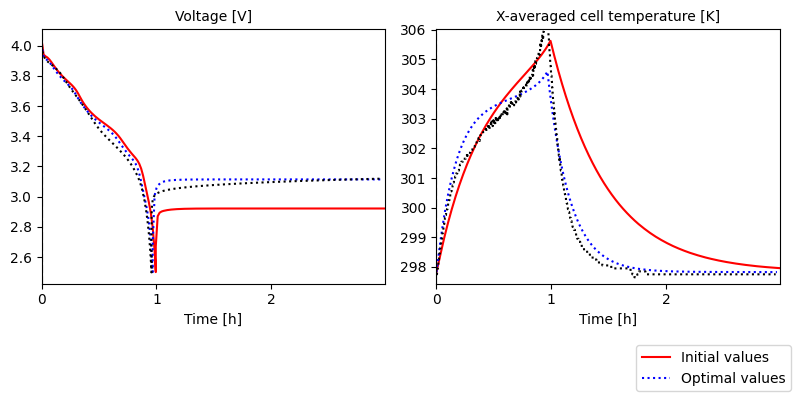

In [14]:
print(result)
result.plot()

We can also just print the `result_dict` variable of the result, which is more readable for problems with many parameters to fit.

In [15]:
result.result_dict

{'Negative electrode diffusivity [m2.s-1]': 1.6262415932624866e-14,
 'Negative electrode reaction coefficient': 4.284556342749176e-07,
 'Total heat transfer coefficient [W.m-2.K-1]': 30.93789568920101,
 'Positive current collector specific heat capacity [J.kg-1.K-1]': 1744.6295799221168,
 'Negative current collector specific heat capacity [J.kg-1.K-1]': 1744.6295799221168,
 'Negative electrode specific heat capacity [J.kg-1.K-1]': 1744.6295799221168,
 'Separator specific heat capacity [J.kg-1.K-1]': 1744.6295799221168,
 'Positive electrode specific heat capacity [J.kg-1.K-1]': 1744.6295799221168}